In [26]:
import sys
import psycopg2
import pandas.io.sql as psql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error

import my_pass
%matplotlib inline

In [103]:
def reading(host, DB, username, password):
    conn_string = "host=" + host + " dbname=" + DB + " user=" + username + " password=" + password
    # get connected to the database
    connection = psycopg2.connect(conn_string)
    query = "SELECT * FROM b2w_schema.sales_agg;"
    sales = psql.read_sql(query, connection)
    # Here I'm only selecting immeadiate pay
    query = "SELECT prod_id,date_order,competitor, min(competitor_price) as competitor_price\
            FROM b2w_schema.comp_prices \
            GROUP BY prod_id,date_order,competitor,pay_type \
            HAVING pay_type = 2;"
    price_im = psql.read_sql(query, connection)
    return (sales,price_im)

In [138]:
class ml_models(object):

    def __init__(self, data, product):
        self.df = data
        self.product = product

    def prepare_data(self):
        # selecting a specific product to analyse
        self.df = self.df[self.df['prod_id'] == self.product]

        # Remove columns that only have missing values
        self.df = self.df.dropna(axis=1,how='all')

        # Transforming categorical varibales into factors
        le_day_week = preprocessing.LabelEncoder()
        self.df['day_week'] = le_day_week.fit_transform(self.df['day_week'])
        self.df['month'] = le_day_week.fit_transform(self.df['month'])

    def fill_comp_price_NA(self,col):
        df = self.df[['price','C1','C2','C3','C4','C5','C6']]
        df.drop(col, axis=1, inplace=False)
        self.df.loc[:,('aux_col')] = df.mean(axis=1, skipna = True)
        null_rows = self.df.loc[:,(col)].isnull()
        self.df.loc[null_rows,(col)] = self.df.loc[null_rows,('aux_col')]
        self.df.drop('aux_col', axis=1, inplace=True)
    
    def make_train_test(self,frac = 0.8, random_state = 200):
        # creating a training and test sets
        self.df_train = self.df.sample(frac = frac, random_state = random_state)
        self.df_test = self.df.drop(self.df_train.index)
        
    def select_X_Y(self,Y, X_keep = [], X_drop = []):
        
        # Isolate Response variable
        self.Y_train, self.Y_test = self.df_train[Y], self.df_test[Y]

        # warning: drop_feat overrides keep_feat !!!
        if X_drop:
            self.X_train = self.df_train.drop(X_drop, axis=1, inplace=False)
            self.X_test = self.df_test.drop(X_drop, axis=1, inplace=False)
        elif X_keep:
            self.X_train = self.df_train[X_keep]
            self.X_test = self.df_test[X_keep]

        # Remove Response variable from regressor set
        self.X_train.drop(Y, axis=1, inplace=True)
        self.X_test.drop(Y, axis=1, inplace=True)

        # Total number of regressors
        self.n_regressors = len(self.X_test.columns)

    def predict_test(self, print_mse = True):
        # Predict and update dataset
        self.Y_pred = self.clf.predict(self.X_test)
        mse = mean_squared_error(self.Y_test, self.Y_pred)
        if print_mse:
            print "MSE: %.4f" % mean_squared_error(self.Y_test, self.Y_pred)

In [139]:
class GBM(ml_models):
    # Gradient Boosting
    def __init__(self, data, product):
        ml_models.__init__(self, data, product)

    def fit_gb(self, params):
        # Fit model
        print self.X_train.columns
        self.clf = GradientBoostingRegressor(**params)
        self.clf.fit(self.X_train, self.Y_train)

    def plot_feature_importance(self, n):
        importances = self.clf.feature_importances_
        feature_names = self.X_test.columns
        indices = np.argsort(importances)[::-1][:n]
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(10,6)
        plt.title("Feature importances", fontsize = 16)
        xlabels = [feature_names[int(i)] for i in indices]
        plt.bar(range(n), importances[indices],
                color="#799DBB",  align="center")
        plt.grid()
        plt.xticks(range(n), xlabels, rotation=90)
        plt.xlim([-1, n])
        plt.ylim([0, min(1, max(importances[indices]+0.0005))])
        plt.xlabel('Features', fontsize = 14)
        plt.ylabel('Feature Importance', fontsize = 14)
        plt.title('Product '+  self.product +' Variable Importance')
        plt.show()

In [140]:
class MLR(ml_models):
    # Multiple linear regression
    def __init__(self, data, product):
        ml_models.__init__(self, data, product)

    def fit_mlr(self):
        # Fit model
        self.clf = linear_model.LinearRegression(fit_intercept=False)
        self.clf.fit(self.X_train, self.Y_train)
        print self.clf.coef_

# Analysis

## Reading Data

In [141]:
# User inputs
host = 'localhost'
DB = 'postgres'
username = my_pass.username
password = my_pass.password

# Reading tables
sales, price_im = reading(host, DB, username, password)

## Feature Engineering

In [187]:
# Reshaping the data to perform a join in order to get Competitor's Prices
price_im_wide = pd.pivot_table(price_im, index = ['prod_id','date_order'], columns = ['competitor'], values = 'competitor_price')
price_im_wide.reset_index(inplace = True)
df = pd.merge(sales, price_im_wide, how='left', on=['prod_id','date_order'])

# Reshaping the data to perform a join in order to get the Product's Prices
day_price_prod_wide = pd.pivot_table(day_price_prod, index = ['date_order'], columns = ['prod_id'], values = 'price')
day_price_prod_wide.reset_index(inplace = True)
df = pd.merge(df, day_price_prod_wide, how='left', on=['date_order'])

# Quantity sold from previous day
df['qty_lag_1'] = df['qty_order'].shift(1)
df.loc[0,('qty_lag_1')] = df.loc[1,('qty_lag_1')]

# Cumsum of Past 3 days
# To-do

In [ ]:
class Feature_engineering:
    def __init__(self, path, n_rows):
        self.df = self.load_data(path, n_rows)

    def add_cumulative_return(self, cols, n_cum):
        # Adds cumulative sales
        for n in n_cum:
            for variable in cols:
                name = variable + '_cum_' + str(n)
                if variable != 'S1':
                    colnames = [variable + '_lag_' + str(x) for x in range(1,n)]
                    colnames.append(variable)
                else:
                    colnames = [variable + '_lag_' + str(x) for x in range(1,n+1)]
                self.df[name] = exp(self.df[colnames].sum(axis = 1))-1

## Imputing Values

In [188]:
def fill_comp_price_NA(df1,col):
    df1 = df1[['price','C1','C2','C3','C4','C5','C6']]
    df1.drop(col, axis=1, inplace=False)
    df2.loc[:,('aux_col')] = df1.mean(axis=1, skipna = True)
    null_rows = df2.loc[:,(col)].isnull()
    df2.loc[null_rows,(col)] = df2.loc[null_rows,('aux_col')]
    return df2[col]

In [189]:
cols = ['C1','C2','C3','C4','C5','C6']
for col in cols:
    df[col] = fill_comp_price_NA(df,col)

In [190]:
def fill_prod_price_NA(df,col,min_value):
    null_rows = df.loc[:,(col)].isnull()
    df2.loc[null_rows,(col)] = min_value
    return df2[col]

In [191]:
cols = ['P1','P2','P3','P4','P5','P6','P7','P8','P9']
for col in cols:
    min_value = df[col].min(axis = 0, skipna = True)
    df[col] = fill_prod_price_NA(df,col,min_value)

## Fitting Models

In [192]:
gb_p2 = GBM(df, 'P1') 
gb_p2.prepare_data() 
gb_p2.make_train_test()

In [193]:
gb_p2.df_train.head(4)

,prod_id,qty_order,revenue,price,date_order,day_week,month,C1,C2,C3,...,C6,P1,P3,P4,P5,P6,P7,P8,P9,qty_lag_1
1092,P1,5,7495.00,1499.000,2015-08-28,0,6,1319.12,1319.12,1319.1200,...,1376.0820,1325.067654,1057.695652,421.234305,709.862283,1388.826562,681.916511,370.819467,370.300191,912
233,P1,5,7395.00,1479.000,2015-02-25,6,0,1479.00,1479.00,1479.0000,...,1479.0000,1325.067654,1057.695652,421.234305,709.862283,1388.826562,681.916511,370.819467,370.300191,23
1116,P1,10,14981.17,1498.117,2015-06-17,6,4,1090.00,1099.00,1099.0000,...,1242.0334,1325.067654,1057.695652,421.234305,709.862283,1388.826562,681.916511,370.819467,370.300191,31
597,P1,5,6895.40,1379.080,2015-08-25,5,6,1499.00,1499.00,1450.2825,...,1450.2825,1325.067654,1057.695652,421.234305,709.862283,1388.826562,681.916511,370.819467,370.300191,7


In [194]:
gb_p2.select_X_Y(Y = 'qty_order', X_drop = ['prod_id','revenue','date_order'])

In [195]:
# Fit
params = {'n_estimators': 1000, 'max_depth': 2, 'max_features': 'sqrt', 'random_state': 5}
gb_p2.fit_gb(params)

Index([u'price', u'day_week', u'month', u'C1', u'C2', u'C3', u'C4', u'C5',
       u'C6', u'P1', u'P3', u'P4', u'P5', u'P6', u'P7', u'P8', u'P9',
       u'qty_lag_1'],
      dtype='object')


In [196]:
# Predict
gb_p2.predict_test()
d = {'price': gb_p2.X_test['price'], 'Y_test': gb_p2.Y_test, 'Y_pred': gb_p2.Y_pred}
ans_df = pd.DataFrame(data=d)
ans_df.head(10)

MSE: 176.2867


,Y_pred,Y_test,price
4,15.925959,10,1449.000000
76,23.655520,9,1499.000000
138,28.182402,19,1431.897368
172,17.519201,9,1487.888889
204,13.189800,11,1465.263636
242,6.721759,7,1499.000000
245,36.748815,17,1392.584118
297,16.292059,21,1381.361905
356,2.994342,2,1499.000000
429,8.921213,13,1467.500000


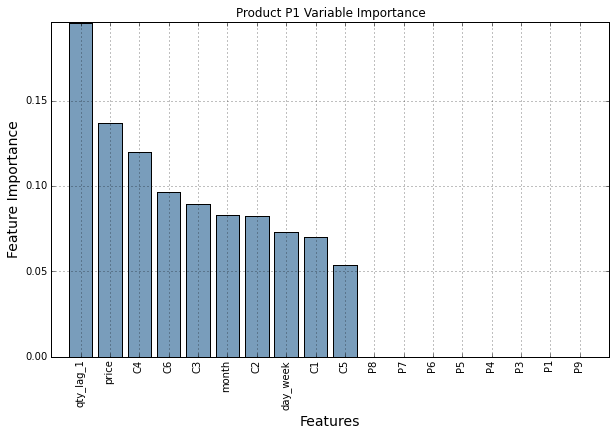

In [197]:
# Plot feature importance
gb_p2.plot_feature_importance(gb_p2.n_regressors)